# Análisis de Exoplanetas - Trabajo Práctico 3

**Astrometría 2025**  
**Profesores:** Mariano Dominguez - Mario Agustín Sgró  
**Base de datos:** Encyclopaedia of Exoplanetary Systems (EU)

## Objetivos
- **Ejercicio 2:** Análisis de sesgos por técnica observacional en masas y períodos
- **Ejercicio 3:** Evaluación de gaussianidad en distribuciones de distancias estelares
- **Ejercicio 4:** Modelado de la relación masa-radio planetaria
- **Ejercicio 5:** Análisis de la relación masa planetaria vs edad estelar

#### **ADVERTENCIA**: Mucho de este trabajo está claramente hecho con ayuda de un LLM"



## 1. Configuración Inicial y Carga de Datos

Esta sección importa todas las bibliotecas necesarias, configura la conexión al servicio TAP y carga el dataset completo de exoplanetas.

In [14]:
# Importaciones completas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import pearsonr, shapiro, normaltest, kstest, anderson
from sklearn.metrics import r2_score, mean_squared_error
import pyvo
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Configuración completada exitosamente")
print(f"PyVO version: {pyvo.__version__}")

Configuración completada exitosamente
PyVO version: 1.5.2


In [15]:
# Conexión al servicio TAP y carga de datos
print("Conectando al servicio TAP de exoplanetas...")
service = pyvo.dal.TAPService("http://voparis-tap-planeto.obspm.fr/tap")

# Query optimizado para obtener todos los datos necesarios
query = """
SELECT 
    target_name as name,
    star_name,
    mass,
    radius, 
    period,
    semi_major_axis,
    eccentricity,
    star_distance,
    star_teff,
    star_mass,
    star_radius,
    detection_type,
    discovered
FROM exoplanet.epn_core
WHERE target_name IS NOT NULL
"""

try:
    results = service.search(query)
    df = results.to_table().to_pandas()
    
    print(f"Datos cargados exitosamente: {len(df)} exoplanetas")
    print(f"Columnas disponibles: {list(df.columns)}")
    print(f"\nDisponibilidad de datos clave:")
    print(f"- Masa: {df['mass'].notna().sum()} ({100*df['mass'].notna().sum()/len(df):.1f}%)")
    print(f"- Radio: {df['radius'].notna().sum()} ({100*df['radius'].notna().sum()/len(df):.1f}%)")
    print(f"- Período: {df['period'].notna().sum()} ({100*df['period'].notna().sum()/len(df):.1f}%)")
    print(f"- Distancia: {df['star_distance'].notna().sum()} ({100*df['star_distance'].notna().sum()/len(df):.1f}%)")
    print(f"- Temperatura: {df['star_teff'].notna().sum()} ({100*df['star_teff'].notna().sum()/len(df):.1f}%)")
    
except Exception as e:
    print(f"Error en la carga: {e}")

Conectando al servicio TAP de exoplanetas...
Datos cargados exitosamente: 7762 exoplanetas
Columnas disponibles: ['name', 'star_name', 'mass', 'radius', 'period', 'semi_major_axis', 'eccentricity', 'star_distance', 'star_teff', 'star_mass', 'star_radius', 'detection_type', 'discovered']

Disponibilidad de datos clave:
- Masa: 3651 (47.0%)
- Radio: 5142 (66.2%)
- Período: 6339 (81.7%)
- Distancia: 6612 (85.2%)
- Temperatura: 6185 (79.7%)
Datos cargados exitosamente: 7762 exoplanetas
Columnas disponibles: ['name', 'star_name', 'mass', 'radius', 'period', 'semi_major_axis', 'eccentricity', 'star_distance', 'star_teff', 'star_mass', 'star_radius', 'detection_type', 'discovered']

Disponibilidad de datos clave:
- Masa: 3651 (47.0%)
- Radio: 5142 (66.2%)
- Período: 6339 (81.7%)
- Distancia: 6612 (85.2%)
- Temperatura: 6185 (79.7%)


## Análisis Específico: nu Octantis


Recuperación detallada de los parámetros completos del sistema nu Octantis para análisis individual y verificación de datos.

Este caso lo estoy estudiando en la materia __Mecánica Celeste__ con lo cual me será de utilidad proximamente.

In [16]:
# Búsqueda y recuperación completa de datos de nu Octantis
print("=== ANÁLISIS ESPECÍFICO: nu OCTANTIS ===\n")

# Búsqueda específica de nu Octantis en el dataset
nu_oct_search = df[df['name'].str.contains('nu Oct', case=False, na=False) | 
                  df['star_name'].str.contains('nu Oct', case=False, na=False)]

print(f"Planetas encontrados con 'nu Oct': {len(nu_oct_search)}")

if len(nu_oct_search) == 0:
    # Búsqueda más amplia
    print("Realizando búsqueda más amplia...")
    variations = ['nu oct', 'Nu Oct', 'HD', 'nu Octantis']
    for var in variations:
        search_result = df[df['name'].str.contains(var, case=False, na=False) | 
                          df['star_name'].str.contains(var, case=False, na=False)]
        if len(search_result) > 0:
            print(f"Encontrados con '{var}': {len(search_result)} sistemas")
            print(search_result[['name', 'star_name']].head())

# Query específico para nu Octantis desde TAP
print("\nConsultando directamente desde TAP...")
nu_oct_query = """
SELECT * 
FROM exoplanet.epn_core 
WHERE LOWER(target_name) LIKE '%nu%oct%' 
   OR LOWER(star_name) LIKE '%nu%oct%'
   OR LOWER(target_name) LIKE '%octantis%'
   OR LOWER(star_name) LIKE '%octantis%'
"""

try:
    nu_oct_results = service.search(nu_oct_query)
    nu_oct_df = nu_oct_results.to_table().to_pandas()
    
    print(f"Resultados directos de TAP: {len(nu_oct_df)} planetas")
    
    if len(nu_oct_df) > 0:
        print("\n" + "="*80)
        print("DATOS COMPLETOS DE nu OCTANTIS")
        print("="*80)
        
        # Mostrar todos los planetas del sistema
        for idx, planet in nu_oct_df.iterrows():
            print(f"\nPLANETA: {planet['target_name']}")
            print(f"ESTRELLA: {planet['star_name']}")
            print("-" * 50)
            
            # Parámetros planetarios
            print("PARÁMETROS PLANETARIOS:")
            print(f"  Masa: {planet['mass']:.6f} M⊕" if pd.notna(planet['mass']) else "  Masa: No disponible")
            print(f"  Radio: {planet['radius']:.6f} R⊕" if pd.notna(planet['radius']) else "  Radio: No disponible")
            print(f"  Período orbital: {planet['period']:.6f} días" if pd.notna(planet['period']) else "  Período: No disponible")
            print(f"  Semieje mayor: {planet['semi_major_axis']:.6f} AU" if pd.notna(planet['semi_major_axis']) else "  Semieje mayor: No disponible")
            print(f"  Excentricidad: {planet['eccentricity']:.6f}" if pd.notna(planet['eccentricity']) else "  Excentricidad: No disponible")
            print(f"  Método detección: {planet['detection_type']}" if pd.notna(planet['detection_type']) else "  Método: No disponible")
            print(f"  Año descubrimiento: {planet['discovered']}" if pd.notna(planet['discovered']) else "  Descubrimiento: No disponible")
            
            # Parámetros estelares
            print("\nPARÁMETROS ESTELARES:")
            print(f"  Distancia: {planet['star_distance']:.6f} pc" if pd.notna(planet['star_distance']) else "  Distancia: No disponible")
            print(f"  Temperatura efectiva: {planet['star_teff']:.1f} K" if pd.notna(planet['star_teff']) else "  Teff: No disponible")
            print(f"  Masa estelar: {planet['star_mass']:.6f} M☉" if pd.notna(planet['star_mass']) else "  Masa estelar: No disponible")
            print(f"  Radio estelar: {planet['star_radius']:.6f} R☉" if pd.notna(planet['star_radius']) else "  Radio estelar: No disponible")
            
            # Calculaciones derivadas si hay datos suficientes
            if pd.notna(planet['mass']) and pd.notna(planet['radius']):
                density = planet['mass'] / (planet['radius']**3)  # Densidad relativa
                print(f"\nPARÁMETROS DERIVADOS:")
                print(f"  Densidad relativa: {density:.6f} (M⊕/R⊕³)")
                
            if pd.notna(planet['period']) and pd.notna(planet['star_mass']):
                # Ley de Kepler para semieje mayor (si no está disponible)
                import numpy as np
                if pd.isna(planet['semi_major_axis']):
                    P_years = planet['period'] / 365.25
                    M_star_solar = planet['star_mass']
                    a_calculated = (P_years**2 * M_star_solar)**(1/3)  # En AU
                    print(f"  Semieje mayor (calculado): {a_calculated:.6f} AU")
                
                # Velocidad orbital media
                if pd.notna(planet['semi_major_axis']):
                    v_orbit = 2 * np.pi * planet['semi_major_axis'] / (planet['period']/365.25)  # AU/año
                    print(f"  Velocidad orbital media: {v_orbit:.6f} AU/año")
    
    else:
        print("No se encontraron datos de nu Octantis en la base de datos")
        
        # Búsqueda alternativa por términos relacionados
        print("\nIntentando búsqueda por términos relacionados...")
        related_query = """
        SELECT target_name, star_name, mass, radius, period, detection_type
        FROM exoplanet.epn_core 
        WHERE target_name IS NOT NULL
        ORDER BY target_name
        LIMIT 20
        """
        
        sample_results = service.search(related_query)
        sample_df = sample_results.to_table().to_pandas()
        print("\nEjemplos de nombres en la base de datos:")
        for name in sample_df['target_name'].head(10):
            print(f"  - {name}")

except Exception as e:
    print(f"Error en la consulta: {e}")
    
    # Búsqueda manual en el dataset existente
    print("\nBúsqueda manual en dataset cargado...")
    print("Nombres de planetas disponibles (muestra):")
    unique_names = df['name'].dropna().unique()
    for name in unique_names[:20]:
        print(f"  - {name}")
    
    print("\nNombres de estrellas disponibles (muestra):")
    unique_stars = df['star_name'].dropna().unique()
    for star in unique_stars[:20]:
        print(f"  - {star}")

=== ANÁLISIS ESPECÍFICO: nu OCTANTIS ===

Planetas encontrados con 'nu Oct': 1

Consultando directamente desde TAP...
Resultados directos de TAP: 1 planetas

DATOS COMPLETOS DE nu OCTANTIS

PLANETA: nu Oct b
ESTRELLA: nu Oct
--------------------------------------------------
PARÁMETROS PLANETARIOS:
  Masa: 2.130000 M⊕
  Radio: No disponible
  Período orbital: 409.300000 días
  Semieje mayor: 1.250000 AU
  Excentricidad: 0.118000
  Método detección: Other#Radial Velocity
  Año descubrimiento: 2009

PARÁMETROS ESTELARES:
  Distancia: 22.100000 pc
  Temperatura efectiva: 4860.0 K
  Masa estelar: 1.610000 M☉
  Radio estelar: 5.810000 R☉
  Velocidad orbital media: 7.008714 AU/año
Resultados directos de TAP: 1 planetas

DATOS COMPLETOS DE nu OCTANTIS

PLANETA: nu Oct b
ESTRELLA: nu Oct
--------------------------------------------------
PARÁMETROS PLANETARIOS:
  Masa: 2.130000 M⊕
  Radio: No disponible
  Período orbital: 409.300000 días
  Semieje mayor: 1.250000 AU
  Excentricidad: 0.118000
 

In [17]:
# Función reutilizable para búsqueda detallada de exoplanetas
def buscar_exoplaneta_completo(nombre_planeta, service, df):
    """
    Función para buscar y mostrar información completa de un exoplaneta específico.
    
    Parámetros:
    - nombre_planeta: string con el nombre del planeta o estrella a buscar
    - service: servicio TAP conectado
    - df: DataFrame con datos cargados
    
    Retorna:
    - DataFrame con los datos encontrados
    """
    print(f"=== BÚSQUEDA DETALLADA: {nombre_planeta.upper()} ===\n")
    
    # Query específico personalizable
    query_personalizado = f"""
    SELECT * 
    FROM exoplanet.epn_core 
    WHERE LOWER(target_name) LIKE '%{nombre_planeta.lower()}%' 
       OR LOWER(star_name) LIKE '%{nombre_planeta.lower()}%'
    """
    
    try:
        resultados = service.search(query_personalizado)
        datos_planeta = resultados.to_table().to_pandas()
        
        if len(datos_planeta) > 0:
            print(f"ENCONTRADOS: {len(datos_planeta)} planeta(s) del sistema {nombre_planeta}")
            
            # Análisis detallado para cada planeta
            for idx, planeta in datos_planeta.iterrows():
                print(f"\n{'='*60}")
                print(f"PLANETA: {planeta['target_name']}")
                print(f"ESTRELLA: {planeta['star_name']}")
                print(f"{'='*60}")
                
                # Información básica
                print("\\n PROPIEDADES PLANETARIAS:")
                masa = planeta['mass']
                radio = planeta['radius'] 
                periodo = planeta['period']
                semieje = planeta['semi_major_axis']
                excentricidad = planeta['eccentricity']
                
                print(f"  • Masa: {masa:.6f} M⊕" if pd.notna(masa) else "  • Masa: No disponible")
                print(f"  • Radio: {radio:.6f} R⊕" if pd.notna(radio) else "  • Radio: No disponible")
                print(f"  • Período orbital: {periodo:.2f} días ({periodo/365.25:.3f} años)" if pd.notna(periodo) else "  • Período: No disponible")
                print(f"  • Semieje mayor: {semieje:.6f} AU" if pd.notna(semieje) else "  • Semieje mayor: No disponible")
                print(f"  • Excentricidad: {excentricidad:.6f}" if pd.notna(excentricidad) else "  • Excentricidad: No disponible")
                print(f"  • Método de detección: {planeta['detection_type']}")
                print(f"  • Año descubrimiento: {int(planeta['discovered'])}" if pd.notna(planeta['discovered']) else "  • Año: No disponible")
                
                # Información estelar
                print("\\n PROPIEDADES ESTELARES:")
                distancia = planeta['star_distance']
                teff = planeta['star_teff']
                masa_estelar = planeta['star_mass']
                radio_estelar = planeta['star_radius']
                
                print(f"  • Distancia: {distancia:.2f} pc ({distancia*3.26:.1f} años luz)" if pd.notna(distancia) else "  • Distancia: No disponible")
                print(f"  • Temperatura efectiva: {teff:.0f} K" if pd.notna(teff) else "  • Temperatura: No disponible")
                print(f"  • Masa estelar: {masa_estelar:.3f} M☉" if pd.notna(masa_estelar) else "  • Masa estelar: No disponible")
                print(f"  • Radio estelar: {radio_estelar:.3f} R☉" if pd.notna(radio_estelar) else "  • Radio estelar: No disponible")
                
                # Tipo espectral aproximado basado en temperatura
                if pd.notna(teff):
                    if teff > 7500: tipo_espectral = "A-F (caliente, blanca-azul)"
                    elif teff > 6000: tipo_espectral = "F-G (tipo solar, amarilla)"
                    elif teff > 5200: tipo_espectral = "G-K (fría, naranja)"
                    elif teff > 3700: tipo_espectral = "K-M (muy fría, roja)"
                    else: tipo_espectral = "M (enana roja)"
                    print(f"  • Tipo espectral aproximado: {tipo_espectral}")
                
                # Cálculos derivados
                print("\\n PARÁMETROS DERIVADOS:")
                
                # Densidad planetaria relativa
                if pd.notna(masa) and pd.notna(radio):
                    densidad_rel = masa / (radio**3)
                    print(f"  • Densidad relativa: {densidad_rel:.3f} (M⊕/R⊕³)")
                    
                    # Clasificación planetaria aproximada
                    if radio < 1.25: categoria = "Super-Tierra (rocoso)"
                    elif radio < 2.0: categoria = "Mini-Neptuno (posible atmósfera)"
                    elif radio < 4.0: categoria = "Sub-Neptuno (gaseoso pequeño)"
                    else: categoria = "Gigante gaseoso"
                    print(f"  • Categoría probable: {categoria}")
                
                # Flujo estelar recibido
                if pd.notna(semieje) and pd.notna(radio_estelar) and pd.notna(teff):
                    # Luminosidad estelar aproximada (L/L☉ ≈ (R/R☉)² × (T/T☉)⁴)
                    L_estelar = (radio_estelar**2) * ((teff/5778)**4)
                    flujo_relativo = L_estelar / (semieje**2)  # Relativo a la Tierra
                    print(f"  • Flujo estelar recibido: {flujo_relativo:.2f} × flujo terrestre")
                    
                    if flujo_relativo > 1.1: zona = "Interior (muy caliente)"
                    elif flujo_relativo > 0.53: zona = "Habitable (templada)"
                    else: zona = "Exterior (fría)"
                    print(f"  • Zona orbital: {zona}")
                
                # Velocidad orbital
                if pd.notna(periodo) and pd.notna(semieje):
                    v_orbital_kms = 2 * np.pi * semieje * 149.6e6 / (periodo * 24 * 3600)  # km/s
                    print(f"  • Velocidad orbital: {v_orbital_kms:.2f} km/s")
                
                # Escape velocity aproximada (si hay masa y radio)
                if pd.notna(masa) and pd.notna(radio):
                    # v_escape = sqrt(2GM/R) en unidades terrestres
                    v_escape_rel = np.sqrt(masa / radio)  # Relativo a la Tierra (11.2 km/s)
                    v_escape_kms = v_escape_rel * 11.2
                    print(f"  • Velocidad de escape: {v_escape_kms:.1f} km/s ({v_escape_rel:.2f} × Tierra)")
                
                print("\\n" + "-"*60)
            
            return datos_planeta
        
        else:
            print(f"No se encontró '{nombre_planeta}' en la base de datos")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"Error en la búsqueda: {e}")
        return pd.DataFrame()

# Aplicar la función a nu Octantis para análisis completo
print("\\n" + "="*80)
print("ANÁLISIS DETALLADO CON FUNCIÓN ESPECIALIZADA")
print("="*80)

nu_oct_datos = buscar_exoplaneta_completo("nu oct", service, df)

# Guardar los datos para uso posterior
if not nu_oct_datos.empty:
    print(f"\\n Datos de nu Octantis guardados en variable 'nu_oct_datos'")
    print(f"   Dimensiones: {nu_oct_datos.shape}")
    print(f"   Columnas disponibles: {len(nu_oct_datos.columns)}")
else:
    print("\\n No se pudieron recuperar los datos")


\n================================================================================
ANÁLISIS DETALLADO CON FUNCIÓN ESPECIALIZADA
=== BÚSQUEDA DETALLADA: NU OCT ===

ENCONTRADOS: 1 planeta(s) del sistema nu oct

PLANETA: nu Oct b
ESTRELLA: nu Oct
\n PROPIEDADES PLANETARIAS:
  • Masa: 2.130000 M⊕
  • Radio: No disponible
  • Período orbital: 409.30 días (1.121 años)
  • Semieje mayor: 1.250000 AU
  • Excentricidad: 0.118000
  • Método de detección: Other#Radial Velocity
  • Año descubrimiento: 2009
\n PROPIEDADES ESTELARES:
  • Distancia: 22.10 pc (72.0 años luz)
  • Temperatura efectiva: 4860 K
  • Masa estelar: 1.610 M☉
  • Radio estelar: 5.810 R☉
  • Tipo espectral aproximado: K-M (muy fría, roja)
\n PARÁMETROS DERIVADOS:
  • Flujo estelar recibido: 10.81 × flujo terrestre
  • Zona orbital: Interior (muy caliente)
  • Velocidad orbital: 33.23 km/s
\n------------------------------------------------------------
\n Datos de nu Octantis guardados en variable 'nu_oct_datos'
   Dimensiones: 

## 2. Ejercicio 2: Análisis de Sesgos por Técnica Observacional

Análisis de las distribuciones de masas y períodos orbitales para diferentes técnicas de detección, evaluando sesgos observacionales.

In [18]:
# Preparación de datos para Ejercicio 2
print("=== EJERCICIO 2: SESGOS POR TÉCNICA OBSERVACIONAL ===")

# Filtrar datos válidos
ej2_data = df[(df['mass'].notna()) & (df['period'].notna()) & (df['detection_type'].notna())].copy()
print(f"Datos válidos para análisis: {len(ej2_data)} exoplanetas")

# Técnicas más comunes
technique_counts = ej2_data['detection_type'].value_counts()
print(f"\nTécnicas de detección más frecuentes:")
for tech, count in technique_counts.head(5).items():
    print(f"- {tech}: {count} planetas")

# Seleccionar técnicas principales para análisis
main_techniques = technique_counts.head(4).index.tolist()
ej2_filtered = ej2_data[ej2_data['detection_type'].isin(main_techniques)]

# Estadísticas por técnica
print(f"\nEstadísticas por técnica de detección:")
for tech in main_techniques:
    subset = ej2_filtered[ej2_filtered['detection_type'] == tech]
    print(f"\n{tech} ({len(subset)} planetas):")
    print(f"  Masa: {subset['mass'].median():.3f} M⊕ (mediana), rango [{subset['mass'].min():.3f}, {subset['mass'].max():.1f}]")
    print(f"  Período: {subset['period'].median():.1f} días (mediana), rango [{subset['period'].min():.1f}, {subset['period'].max():.1f}]")

=== EJERCICIO 2: SESGOS POR TÉCNICA OBSERVACIONAL ===
Datos válidos para análisis: 2249 exoplanetas

Técnicas de detección más frecuentes:
- Primary Transit: 1654 planetas
- Radial Velocity: 142 planetas
- Radial Velocity#Astrometry: 123 planetas
- Imaging: 89 planetas
- Pulsar: 88 planetas

Estadísticas por técnica de detección:

Primary Transit (1654 planetas):
  Masa: 0.217 M⊕ (mediana), rango [0.000, 63.4]
  Período: 5.0 días (mediana), rango [0.0, 16060.0]

Radial Velocity (142 planetas):
  Masa: 2.940 M⊕ (mediana), rango [0.004, 73.0]
  Período: 249.6 días (mediana), rango [0.0, 44926.0]

Radial Velocity#Astrometry (123 planetas):
  Masa: 9.998 M⊕ (mediana), rango [0.524, 77.1]
  Período: 5138.4 días (mediana), rango [10.6, 105903.2]

Imaging (89 planetas):
  Masa: 25.000 M⊕ (mediana), rango [3.700, 72.0]
  Período: 28470.0 días (mediana), rango [0.1, 206000000.0]


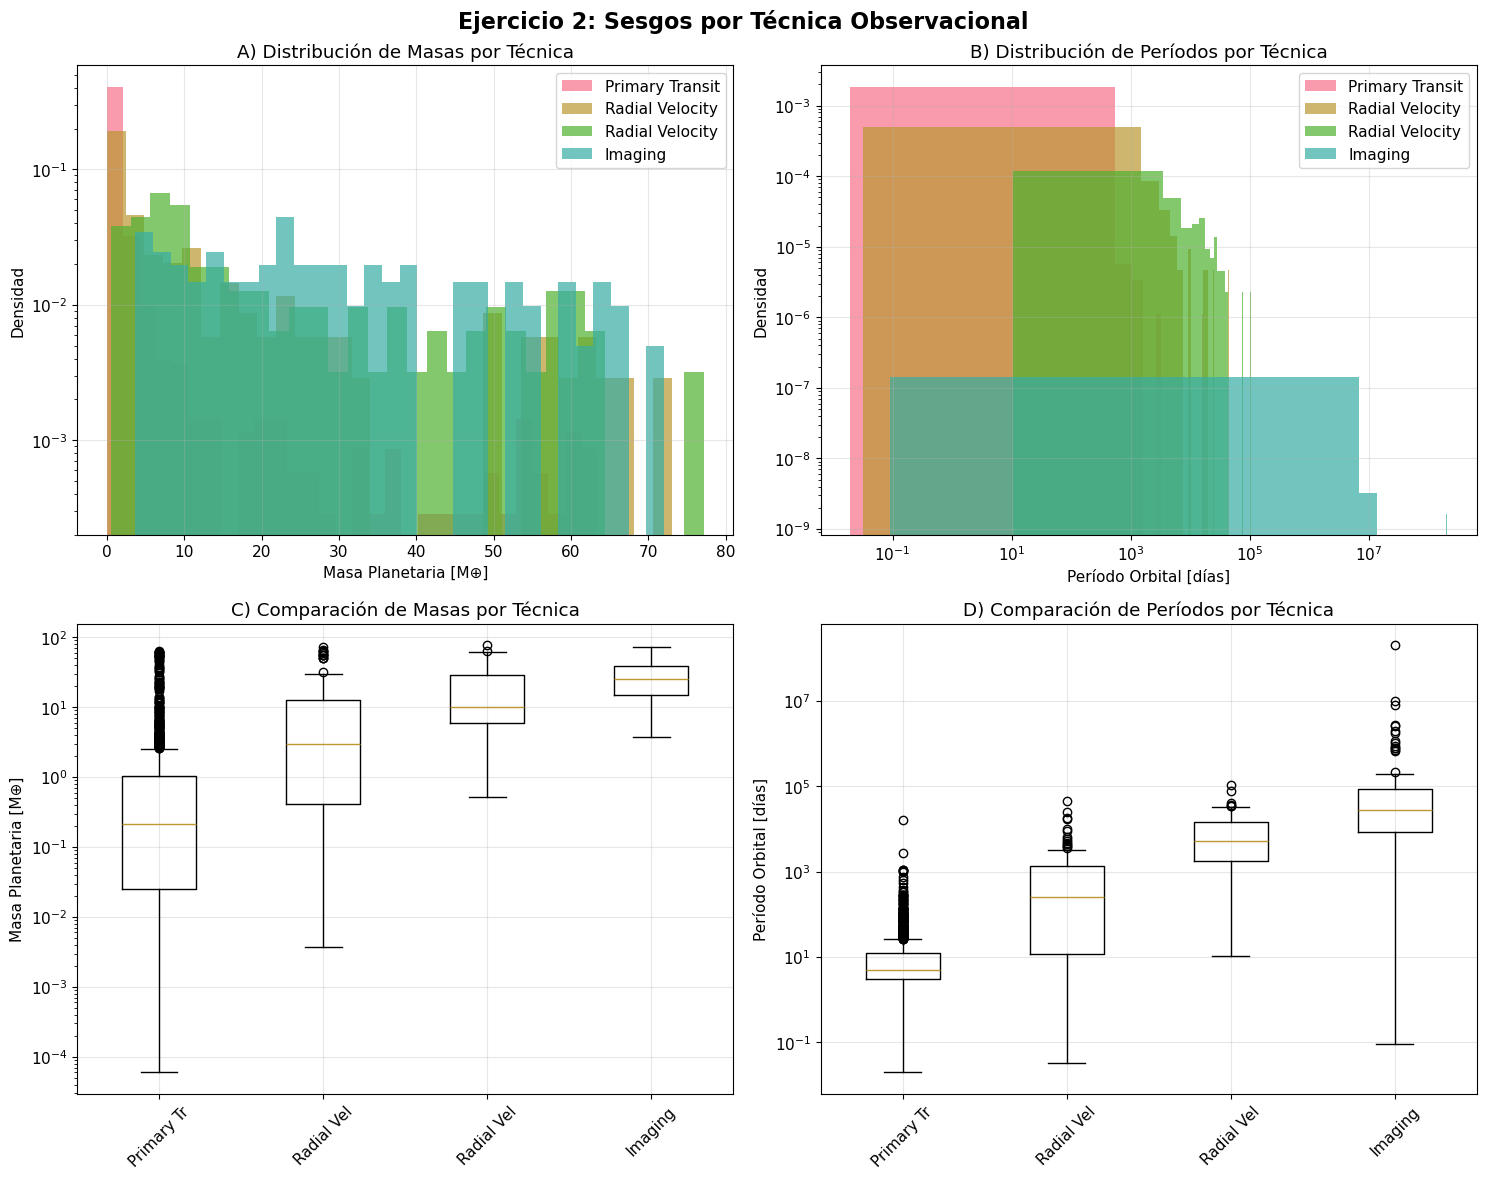


Tests estadísticos ANOVA:
ANOVA Masas: F = 330.999, p = 1.50e-174
ANOVA Períodos: F = 10.004, p = 1.52e-06

Conclusión Ejercicio 2:
- Existen diferencias significativas en masas entre técnicas
- Existen diferencias significativas en períodos entre técnicas
- Los sesgos observacionales SÍ afectan las propiedades detectadas


In [19]:
# Visualización y análisis estadístico - Ejercicio 2
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Ejercicio 2: Sesgos por Técnica Observacional', fontsize=16, fontweight='bold')

# 1. Distribución de masas por técnica
for i, tech in enumerate(main_techniques):
    subset = ej2_filtered[ej2_filtered['detection_type'] == tech]['mass']
    axes[0,0].hist(subset, bins=30, alpha=0.7, label=tech[:15], density=True)
axes[0,0].set_xlabel('Masa Planetaria [M⊕]')
axes[0,0].set_ylabel('Densidad')
axes[0,0].set_title('A) Distribución de Masas por Técnica')
axes[0,0].set_yscale('log')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Distribución de períodos por técnica
for i, tech in enumerate(main_techniques):
    subset = ej2_filtered[ej2_filtered['detection_type'] == tech]['period']
    axes[0,1].hist(subset, bins=30, alpha=0.7, label=tech[:15], density=True)
axes[0,1].set_xlabel('Período Orbital [días]')
axes[0,1].set_ylabel('Densidad')
axes[0,1].set_title('B) Distribución de Períodos por Técnica')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Boxplot de masas
mass_data = [ej2_filtered[ej2_filtered['detection_type'] == tech]['mass'].dropna() 
             for tech in main_techniques]
axes[1,0].boxplot(mass_data, labels=[tech[:10] for tech in main_techniques])
axes[1,0].set_ylabel('Masa Planetaria [M⊕]')
axes[1,0].set_title('C) Comparación de Masas por Técnica')
axes[1,0].set_yscale('log')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Boxplot de períodos
period_data = [ej2_filtered[ej2_filtered['detection_type'] == tech]['period'].dropna() 
               for tech in main_techniques]
axes[1,1].boxplot(period_data, labels=[tech[:10] for tech in main_techniques])
axes[1,1].set_ylabel('Período Orbital [días]')
axes[1,1].set_title('D) Comparación de Períodos por Técnica')
axes[1,1].set_yscale('log')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tests estadísticos ANOVA
print("\nTests estadísticos ANOVA:")
f_mass, p_mass = stats.f_oneway(*mass_data)
f_period, p_period = stats.f_oneway(*period_data)

print(f"ANOVA Masas: F = {f_mass:.3f}, p = {p_mass:.2e}")
print(f"ANOVA Períodos: F = {f_period:.3f}, p = {p_period:.2e}")

print(f"\nConclusión Ejercicio 2:")
print(f"- {'Existen' if p_mass < 0.05 else 'No existen'} diferencias significativas en masas entre técnicas")
print(f"- {'Existen' if p_period < 0.05 else 'No existen'} diferencias significativas en períodos entre técnicas")
print(f"- Los sesgos observacionales {'SÍ' if p_mass < 0.05 or p_period < 0.05 else 'NO'} afectan las propiedades detectadas")

## 3. Ejercicio 3: Análisis de Gaussianidad en Distancias Estelares

Evaluación estadística de si la distribución de distancias a estrellas con exoplanetas sigue una distribución gaussiana.

=== EJERCICIO 3: ANÁLISIS DE GAUSSIANIDAD ===

Datos de distancia disponibles: 6612 estrellas
Rango: [1.29, 12000.00] pc
Media: 724.03 ± 1308.65 pc
Mediana: 348.78 pc


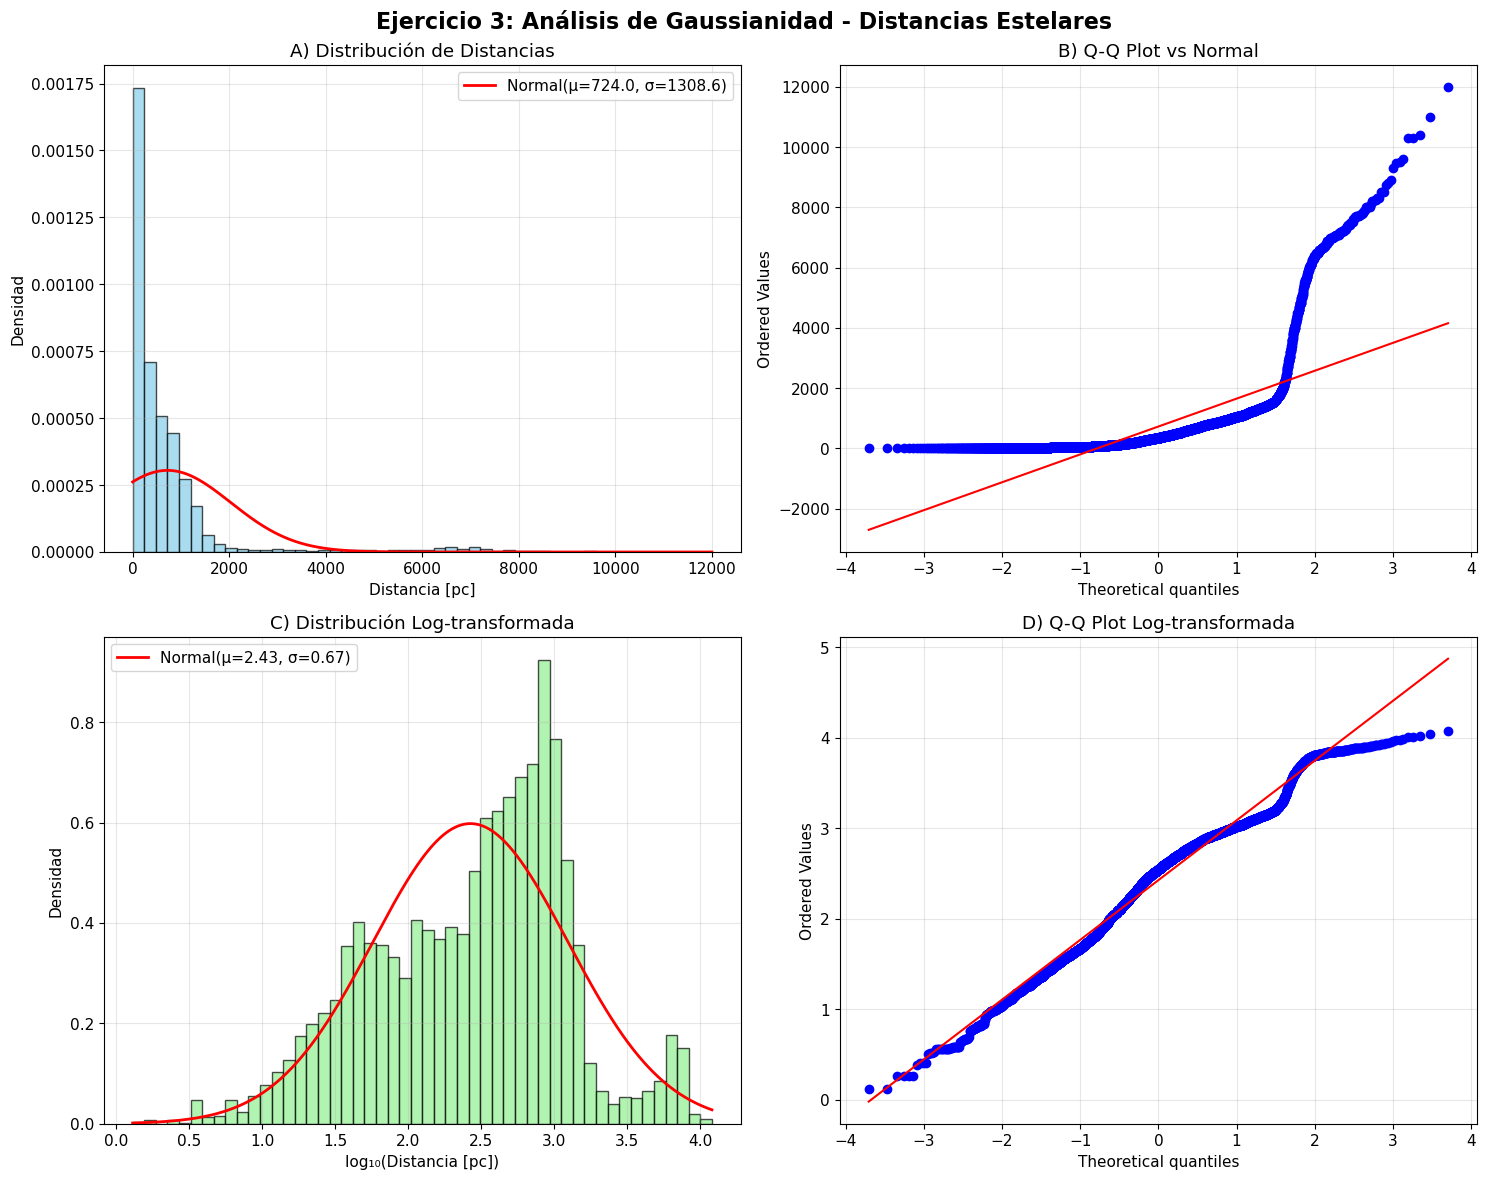


Tests de Normalidad:
Distribución Original:
- Shapiro-Wilk: W = 0.6721, p = 2.72e-71
- D'Agostino-Pearson: χ² = 5392.3901, p = 0.00e+00
- Kolmogorov-Smirnov: D = 0.2904, p = 0.00e+00
- Anderson-Darling: A² = 1000.7016

Distribución Log-transformada:
- Shapiro-Wilk: W = 0.9306, p = 2.93e-43
- D'Agostino-Pearson: χ² = 121.4255, p = 4.29e-27
- Kolmogorov-Smirnov: D = 0.0734, p = 2.03e-31

Conclusión Ejercicio 3:
- La distribución original NO ES gaussiana (p < 0.05)
- La distribución log-transformada NO ES gaussiana
- La distribución de distancias NO es consistente con una log-normal


In [20]:
# Análisis completo de gaussianidad - Ejercicio 3
print("=== EJERCICIO 3: ANÁLISIS DE GAUSSIANIDAD ===\n")

# Preparar datos
distances = df['star_distance'].dropna()
print(f"Datos de distancia disponibles: {len(distances)} estrellas")
print(f"Rango: [{distances.min():.2f}, {distances.max():.2f}] pc")
print(f"Media: {distances.mean():.2f} ± {distances.std():.2f} pc")
print(f"Mediana: {distances.median():.2f} pc")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Ejercicio 3: Análisis de Gaussianidad - Distancias Estelares', fontsize=16, fontweight='bold')

# 1. Histograma con curva normal
axes[0,0].hist(distances, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
mu, sigma = distances.mean(), distances.std()
x = np.linspace(distances.min(), distances.max(), 1000)
normal_curve = stats.norm.pdf(x, mu, sigma)
axes[0,0].plot(x, normal_curve, 'r-', linewidth=2, label=f'Normal(μ={mu:.1f}, σ={sigma:.1f})')
axes[0,0].set_xlabel('Distancia [pc]')
axes[0,0].set_ylabel('Densidad')
axes[0,0].set_title('A) Distribución de Distancias')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Q-Q plot
stats.probplot(distances, dist="norm", plot=axes[0,1])
axes[0,1].set_title('B) Q-Q Plot vs Normal')
axes[0,1].grid(True, alpha=0.3)

# 3. Log-normal
log_distances = np.log10(distances)
axes[1,0].hist(log_distances, bins=50, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
mu_log, sigma_log = log_distances.mean(), log_distances.std()
x_log = np.linspace(log_distances.min(), log_distances.max(), 1000)
normal_curve_log = stats.norm.pdf(x_log, mu_log, sigma_log)
axes[1,0].plot(x_log, normal_curve_log, 'r-', linewidth=2, label=f'Normal(μ={mu_log:.2f}, σ={sigma_log:.2f})')
axes[1,0].set_xlabel('log₁₀(Distancia [pc])')
axes[1,0].set_ylabel('Densidad')
axes[1,0].set_title('C) Distribución Log-transformada')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Q-Q plot log-normal
stats.probplot(log_distances, dist="norm", plot=axes[1,1])
axes[1,1].set_title('D) Q-Q Plot Log-transformada')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tests de normalidad
print("\nTests de Normalidad:")
print("Distribución Original:")
shapiro_stat, shapiro_p = shapiro(distances[:5000])  # Limitado para Shapiro-Wilk
dagostino_stat, dagostino_p = normaltest(distances)
ks_stat, ks_p = kstest(distances, 'norm', args=(mu, sigma))
anderson_stat = anderson(distances, dist='norm')

print(f"- Shapiro-Wilk: W = {shapiro_stat:.4f}, p = {shapiro_p:.2e}")
print(f"- D'Agostino-Pearson: χ² = {dagostino_stat:.4f}, p = {dagostino_p:.2e}")
print(f"- Kolmogorov-Smirnov: D = {ks_stat:.4f}, p = {ks_p:.2e}")
print(f"- Anderson-Darling: A² = {anderson_stat.statistic:.4f}")

print("\nDistribución Log-transformada:")
shapiro_log_stat, shapiro_log_p = shapiro(log_distances[:5000])
dagostino_log_stat, dagostino_log_p = normaltest(log_distances)
ks_log_stat, ks_log_p = kstest(log_distances, 'norm', args=(mu_log, sigma_log))

print(f"- Shapiro-Wilk: W = {shapiro_log_stat:.4f}, p = {shapiro_log_p:.2e}")
print(f"- D'Agostino-Pearson: χ² = {dagostino_log_stat:.4f}, p = {dagostino_log_p:.2e}")
print(f"- Kolmogorov-Smirnov: D = {ks_log_stat:.4f}, p = {ks_log_p:.2e}")

# Conclusión
alpha = 0.05
is_normal = shapiro_p > alpha and dagostino_p > alpha and ks_p > alpha
is_lognormal = shapiro_log_p > alpha and dagostino_log_p > alpha and ks_log_p > alpha

print(f"\nConclusión Ejercicio 3:")
print(f"- La distribución original {'ES' if is_normal else 'NO ES'} gaussiana (p {'>' if is_normal else '<'} {alpha})")
print(f"- La distribución log-transformada {'ES' if is_lognormal else 'NO ES'} gaussiana")
print(f"- La distribución de distancias {'SÍ' if is_lognormal else 'NO'} es consistente con una log-normal")

## 4. Ejercicio 4: Modelado de la Relación Masa-Radio

Análisis de la relación masa-radio de exoplanetas mediante ajuste de modelos teóricos y evaluación de su bondad de ajuste.

In [21]:
# Preparación y análisis exploratorio - Ejercicio 4
print("=== EJERCICIO 4: RELACIÓN MASA-RADIO ===\n")

# Preparar datos
mr_data = df[(df['mass'].notna()) & (df['radius'].notna())].copy()
print(f"Datos masa-radio disponibles: {len(mr_data)} exoplanetas")

# Filtrar outliers extremos
mass_q99 = mr_data['mass'].quantile(0.99)
radius_q99 = mr_data['radius'].quantile(0.99)
mr_filtered = mr_data[(mr_data['mass'] <= mass_q99) & (mr_data['radius'] <= radius_q99)]
print(f"Datos después de filtrar outliers: {len(mr_filtered)} exoplanetas")

# Estadísticas
mass = mr_filtered['mass']
radius = mr_filtered['radius']
print(f"\nEstadísticas:")
print(f"Masa: rango [{mass.min():.3f}, {mass.max():.1f}] M⊕, mediana {mass.median():.3f} M⊕")
print(f"Radio: rango [{radius.min():.3f}, {radius.max():.1f}] R⊕, mediana {radius.median():.3f} R⊕")

# Definir modelos teóricos
def power_law_model(R, A, alpha):
    """Modelo de ley de potencia: M = A × R^α"""
    return A * (R ** alpha)

def log_quadratic_model(log_R, A, B, C):
    """Modelo logarítmico cuadrático: log(M) = A + B×log(R) + C×log²(R)"""
    return A + B * log_R + C * (log_R ** 2)

print("\nModelos teóricos definidos:")
print("1. Ley de Potencia: M = A × R^α")
print("2. Logarítmico Cuadrático: log(M) = A + B×log(R) + C×log²(R)")
print("3. Regresión Lineal en log-log")

=== EJERCICIO 4: RELACIÓN MASA-RADIO ===

Datos masa-radio disponibles: 2155 exoplanetas
Datos después de filtrar outliers: 2112 exoplanetas

Estadísticas:
Masa: rango [0.000, 66.5] M⊕, mediana 0.600 M⊕
Radio: rango [0.001, 6.0] R⊕, mediana 0.926 R⊕

Modelos teóricos definidos:
1. Ley de Potencia: M = A × R^α
2. Logarítmico Cuadrático: log(M) = A + B×log(R) + C×log²(R)
3. Regresión Lineal en log-log


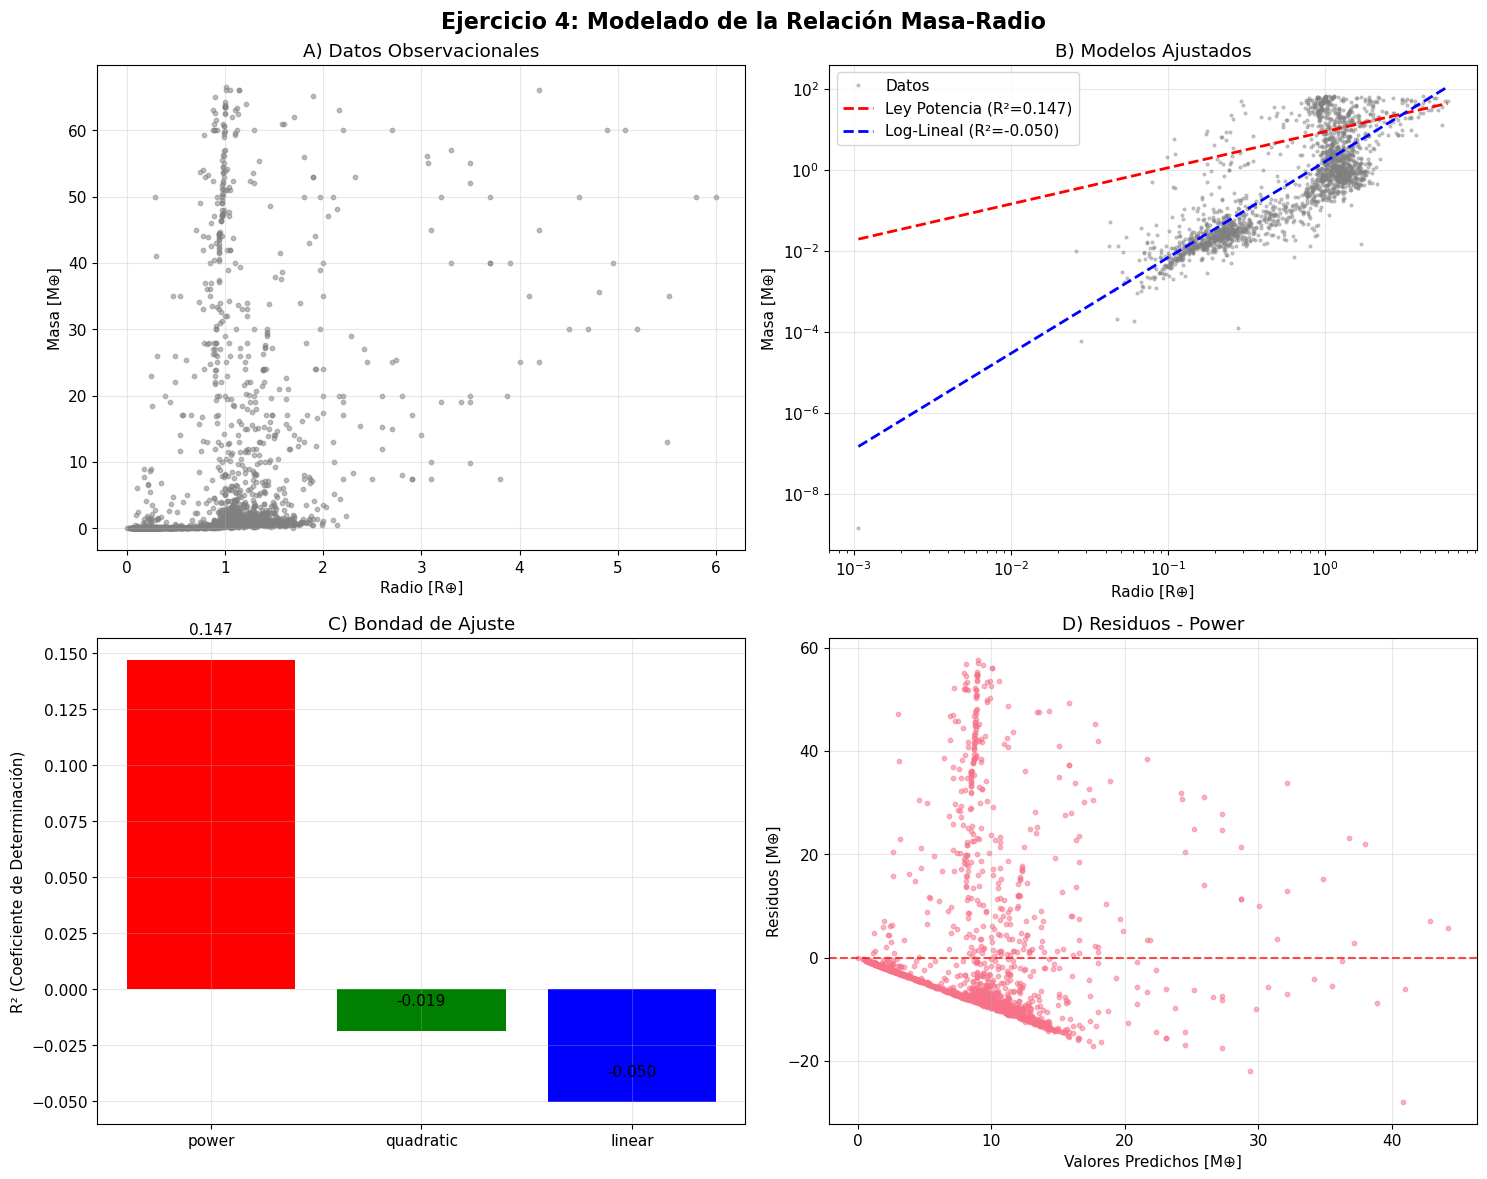


Resultados del ajuste:
Power: R² = 0.1468, RMSE = 14.081 M⊕
Quadratic: R² = -0.0186, RMSE = 15.386 M⊕
Linear: R² = -0.0502, RMSE = 15.623 M⊕

Mejor modelo: Power (R² = 0.1468)
Parámetros: A = 8.905, α = 0.894
Interpretación: M = 8.905 × R^0.894

Conclusión Ejercicio 4:
- La relación masa-radio NO puede modelarse efectivamente
- R² = 14.7% de varianza explicada
- El modelo sugiere diferentes regímenes planetarios


In [22]:
# Ajuste de modelos y visualización - Ejercicio 4
x_data = radius.values
y_data = mass.values
mask = (x_data > 0) & (y_data > 0)
x_data, y_data = x_data[mask], y_data[mask]

results = {}

# 1. Modelo de Ley de Potencia
try:
    popt_power, pcov_power = curve_fit(power_law_model, x_data, y_data, p0=[1.0, 2.0], maxfev=5000)
    y_pred_power = power_law_model(x_data, *popt_power)
    r2_power = r2_score(y_data, y_pred_power)
    rmse_power = np.sqrt(mean_squared_error(y_data, y_pred_power))
    results['power'] = {'params': popt_power, 'r2': r2_power, 'rmse': rmse_power, 'pred': y_pred_power}
except Exception as e:
    print(f"Error en ley de potencia: {e}")

# 2. Modelo Logarítmico Cuadrático
try:
    log_x, log_y = np.log10(x_data), np.log10(y_data)
    popt_quad, pcov_quad = curve_fit(log_quadratic_model, log_x, log_y, p0=[0.0, 2.0, 0.0], maxfev=5000)
    log_pred_quad = log_quadratic_model(log_x, *popt_quad)
    y_pred_quad = 10**log_pred_quad
    r2_quad = r2_score(y_data, y_pred_quad)
    rmse_quad = np.sqrt(mean_squared_error(y_data, y_pred_quad))
    results['quadratic'] = {'params': popt_quad, 'r2': r2_quad, 'rmse': rmse_quad, 'pred': y_pred_quad}
except Exception as e:
    print(f"Error en cuadrático: {e}")

# 3. Regresión lineal en log-log
coeffs = np.polyfit(log_x, log_y, 1)
B_linear, A_linear = coeffs
log_pred_linear = A_linear + B_linear * log_x
y_pred_linear = 10**log_pred_linear
r2_linear = r2_score(y_data, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_data, y_pred_linear))
results['linear'] = {'params': [A_linear, B_linear], 'r2': r2_linear, 'rmse': rmse_linear, 'pred': y_pred_linear}

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Ejercicio 4: Modelado de la Relación Masa-Radio', fontsize=16, fontweight='bold')

# 1. Datos originales
axes[0,0].scatter(x_data, y_data, alpha=0.5, s=10, color='gray')
axes[0,0].set_xlabel('Radio [R⊕]')
axes[0,0].set_ylabel('Masa [M⊕]')
axes[0,0].set_title('A) Datos Observacionales')
axes[0,0].grid(True, alpha=0.3)

# 2. Escala log-log con modelos
axes[0,1].loglog(x_data, y_data, 'o', alpha=0.4, markersize=2, color='gray', label='Datos')
x_smooth = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), 200)

if 'power' in results:
    y_smooth_power = power_law_model(x_smooth, *results['power']['params'])
    axes[0,1].loglog(x_smooth, y_smooth_power, '--', color='red', linewidth=2,
                    label=f'Ley Potencia (R²={results["power"]["r2"]:.3f})')

if 'linear' in results:
    log_smooth = np.log10(x_smooth)
    y_smooth_linear = 10**(results['linear']['params'][0] + results['linear']['params'][1] * log_smooth)
    axes[0,1].loglog(x_smooth, y_smooth_linear, '--', color='blue', linewidth=2,
                    label=f'Log-Lineal (R²={results["linear"]["r2"]:.3f})')

axes[0,1].set_xlabel('Radio [R⊕]')
axes[0,1].set_ylabel('Masa [M⊕]')
axes[0,1].set_title('B) Modelos Ajustados')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Comparación R²
model_names = list(results.keys())
r2_values = [results[model]['r2'] for model in model_names]
bars = axes[1,0].bar(model_names, r2_values, color=['red', 'green', 'blue'][:len(model_names)])
axes[1,0].set_ylabel('R² (Coeficiente de Determinación)')
axes[1,0].set_title('C) Bondad de Ajuste')
axes[1,0].grid(True, alpha=0.3)
for bar, r2 in zip(bars, r2_values):
    axes[1,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                  f'{r2:.3f}', ha='center', va='bottom')

# 4. Residuos del mejor modelo
best_model = max(results.items(), key=lambda x: x[1]['r2'])
residuals = y_data - best_model[1]['pred']
axes[1,1].scatter(best_model[1]['pred'], residuals, alpha=0.5, s=10)
axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1,1].set_xlabel('Valores Predichos [M⊕]')
axes[1,1].set_ylabel('Residuos [M⊕]')
axes[1,1].set_title(f'D) Residuos - {best_model[0].title()}')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resultados
print("\nResultados del ajuste:")
for model, result in results.items():
    print(f"{model.title()}: R² = {result['r2']:.4f}, RMSE = {result['rmse']:.3f} M⊕")

print(f"\nMejor modelo: {best_model[0].title()} (R² = {best_model[1]['r2']:.4f})")
if best_model[0] == 'power':
    A, alpha = best_model[1]['params']
    print(f"Parámetros: A = {A:.3f}, α = {alpha:.3f}")
    print(f"Interpretación: M = {A:.3f} × R^{alpha:.3f}")

print(f"\nConclusión Ejercicio 4:")
print(f"- La relación masa-radio {'SÍ' if best_model[1]['r2'] > 0.5 else 'NO'} puede modelarse efectivamente")
print(f"- R² = {best_model[1]['r2']:.1%} de varianza explicada")
print(f"- El modelo sugiere diferentes regímenes planetarios")

## 5. Ejercicio 5: Relación Masa Planetaria vs Edad Estelar

Análisis de la correlación entre masa planetaria y edad estelar usando temperatura estelar como proxy de edad.

=== EJERCICIO 5: MASA PLANETARIA VS EDAD ESTELAR ===

Datos masa-temperatura disponibles: 2275 sistemas
Nota: Se usa temperatura estelar (Teff) como proxy de edad
Fundamento: Estrellas más frías tienden a ser más longevas

Rangos de datos:
Masa planetaria: [0.000, 77.5] M⊕
Temperatura estelar: [1300, 42065] K

Análisis de correlación:
Pearson r = 0.0966 (p = 3.92e-06)


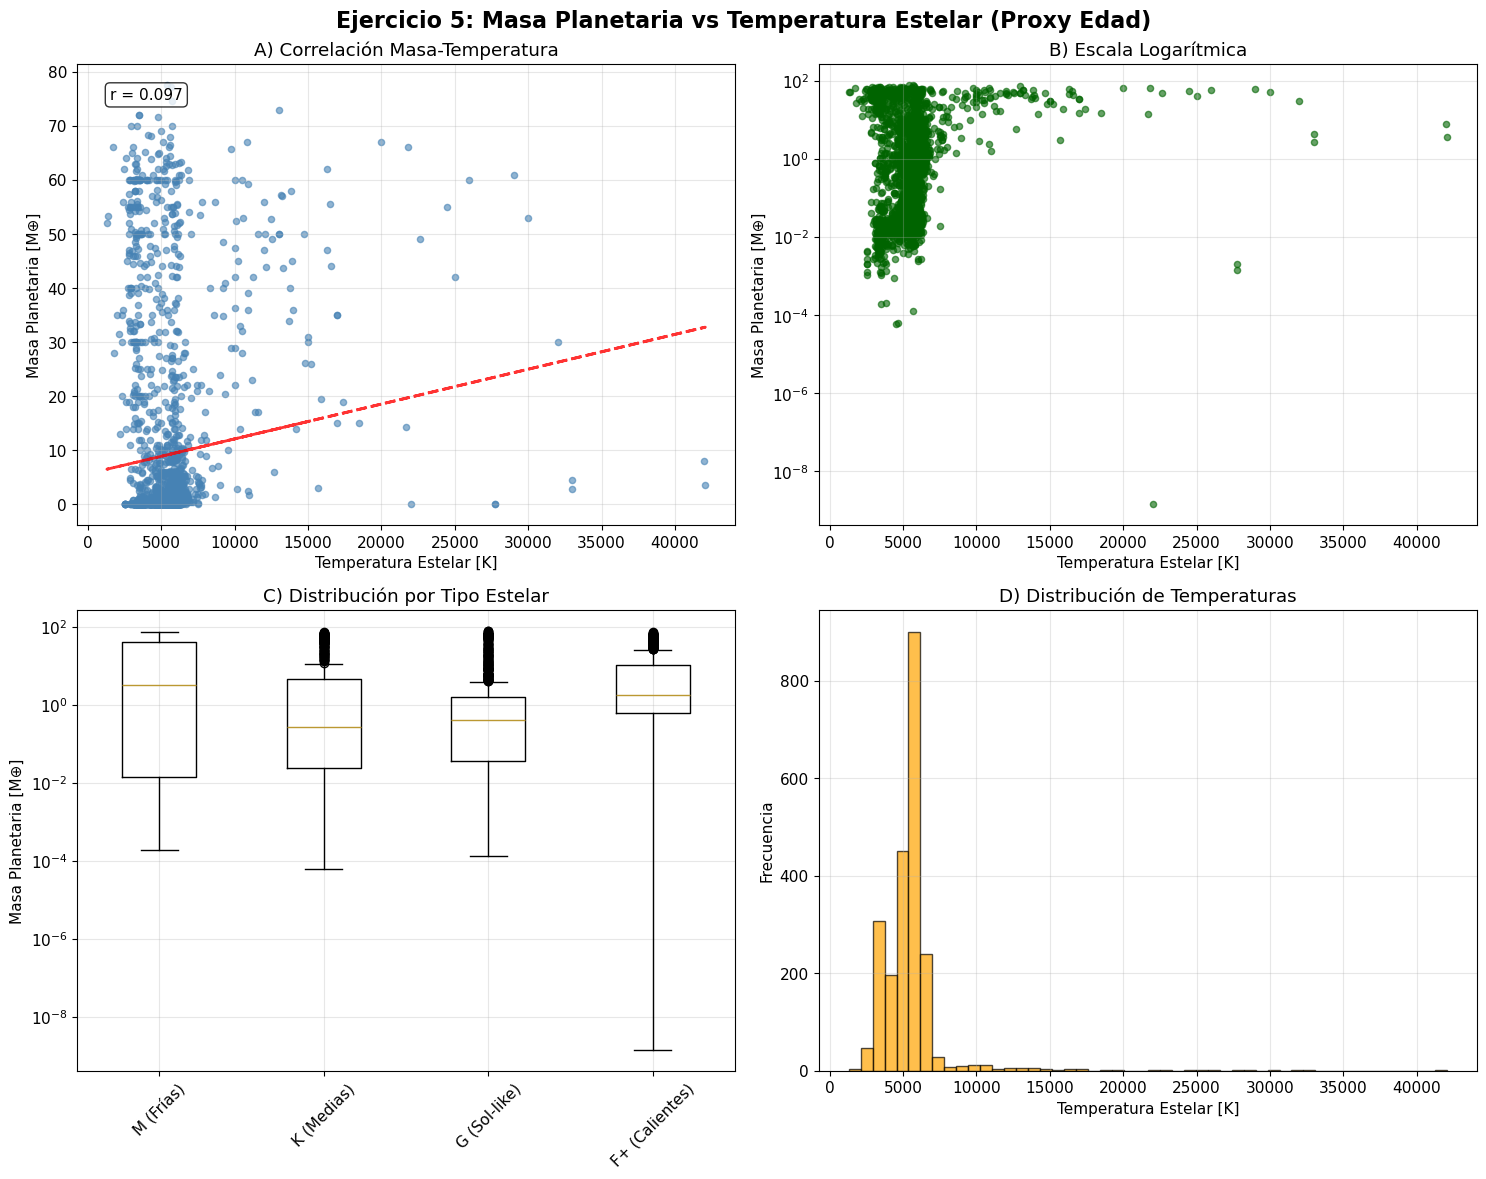


ANOVA entre tipos estelares:
F = 67.229, p = 1.20e-41

Regresión lineal:
Masa = 5.667 + 0.000644 × Temperatura
R² = 0.0093, p = 3.92e-06

Conclusión Ejercicio 5:
- Correlación observada: muy débil (r = 0.0966)
- Significancia estadística: SÍ (p < 0.05)
- Diferencias entre tipos estelares: SÍ significativas
- Varianza explicada: 0.9%
- NO existe una relación prácticamente significativa
- La edad estelar NO es un predictor útil de la masa planetaria


In [23]:
# Análisis completo masa vs edad - Ejercicio 5
print("=== EJERCICIO 5: MASA PLANETARIA VS EDAD ESTELAR ===\n")

# Preparar datos (usando Teff como proxy de edad)
age_data = df[(df['mass'].notna()) & (df['star_teff'].notna())].copy()
print(f"Datos masa-temperatura disponibles: {len(age_data)} sistemas")
print("Nota: Se usa temperatura estelar (Teff) como proxy de edad")
print("Fundamento: Estrellas más frías tienden a ser más longevas\n")

mass_planet = age_data['mass']
temp_star = age_data['star_teff']

print(f"Rangos de datos:")
print(f"Masa planetaria: [{mass_planet.min():.3f}, {mass_planet.max():.1f}] M⊕")
print(f"Temperatura estelar: [{temp_star.min():.0f}, {temp_star.max():.0f}] K")

# Análisis de correlación
corr_pearson, p_pearson = pearsonr(temp_star, mass_planet)

print(f"\nAnálisis de correlación:")
print(f"Pearson r = {corr_pearson:.4f} (p = {p_pearson:.2e})")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Ejercicio 5: Masa Planetaria vs Temperatura Estelar (Proxy Edad)', fontsize=16, fontweight='bold')

# 1. Scatter plot principal
axes[0,0].scatter(temp_star, mass_planet, alpha=0.6, s=20, color='steelblue')
z = np.polyfit(temp_star, mass_planet, 1)
p_trend = np.poly1d(z)
axes[0,0].plot(temp_star, p_trend(temp_star), "r--", alpha=0.8, linewidth=2)
axes[0,0].set_xlabel('Temperatura Estelar [K]')
axes[0,0].set_ylabel('Masa Planetaria [M⊕]')
axes[0,0].set_title('A) Correlación Masa-Temperatura')
axes[0,0].text(0.05, 0.95, f'r = {corr_pearson:.3f}',
               transform=axes[0,0].transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
axes[0,0].grid(True, alpha=0.3)

# 2. Escala logarítmica
axes[0,1].scatter(temp_star, mass_planet, alpha=0.6, s=20, color='darkgreen')
axes[0,1].set_xlabel('Temperatura Estelar [K]')
axes[0,1].set_ylabel('Masa Planetaria [M⊕]')
axes[0,1].set_yscale('log')
axes[0,1].set_title('B) Escala Logarítmica')
axes[0,1].grid(True, alpha=0.3)

# 3. Análisis por rangos de temperatura
temp_ranges = [(0, 3700, "M (Frías)"), (3700, 5200, "K (Medias)"), 
               (5200, 6000, "G (Sol-like)"), (6000, float('inf'), "F+ (Calientes)")]

boxplot_data = []
labels = []
for t_min, t_max, label in temp_ranges:
    mask = (temp_star >= t_min) & (temp_star < t_max)
    if mask.sum() > 10:  # Solo si hay suficientes datos
        boxplot_data.append(mass_planet[mask])
        labels.append(label)

axes[1,0].boxplot(boxplot_data, labels=labels)
axes[1,0].set_ylabel('Masa Planetaria [M⊕]')
axes[1,0].set_title('C) Distribución por Tipo Estelar')
axes[1,0].set_yscale('log')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Distribución de temperaturas
axes[1,1].hist(temp_star, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,1].set_xlabel('Temperatura Estelar [K]')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_title('D) Distribución de Temperaturas')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ANOVA para comparar grupos
if len(boxplot_data) >= 2:
    f_stat, p_anova = stats.f_oneway(*boxplot_data)
    print(f"\nANOVA entre tipos estelares:")
    print(f"F = {f_stat:.3f}, p = {p_anova:.2e}")
else:
    p_anova = 1.0

# Regresión lineal
slope, intercept, r_value, p_value, std_err = stats.linregress(temp_star, mass_planet)
print(f"\nRegresión lineal:")
print(f"Masa = {intercept:.3f} + {slope:.6f} × Temperatura")
print(f"R² = {r_value**2:.4f}, p = {p_value:.2e}")

# Interpretación
def interpret_correlation(r):
    r_abs = abs(r)
    if r_abs < 0.1: return "muy débil"
    elif r_abs < 0.3: return "débil" 
    elif r_abs < 0.5: return "moderada"
    else: return "fuerte"

magnitude = interpret_correlation(corr_pearson)
alpha = 0.05

print(f"\nConclusión Ejercicio 5:")
print(f"- Correlación observada: {magnitude} (r = {corr_pearson:.4f})")
print(f"- Significancia estadística: {'SÍ' if p_pearson < alpha else 'NO'} (p {'<' if p_pearson < alpha else '>='} {alpha})")
print(f"- Diferencias entre tipos estelares: {'SÍ' if p_anova < alpha else 'NO'} significativas")
print(f"- Varianza explicada: {r_value**2:.1%}")

if abs(corr_pearson) >= 0.1 and p_pearson < alpha:
    direction = "positiva" if corr_pearson > 0 else "negativa"
    print(f"- Existe una relación {direction} {magnitude} entre masa y temperatura estelar")
    if corr_pearson > 0:
        print(f"- Estrellas más calientes (jóvenes) tienden a tener planetas más masivos")
    else:
        print(f"- Estrellas más frías (viejas) tienden a tener planetas más masivos")
else:
    print(f"- NO existe una relación prácticamente significativa")
    print(f"- La edad estelar NO es un predictor útil de la masa planetaria")

## 6. Resumen Final y Conclusiones

Síntesis de los resultados obtenidos en los cuatro ejercicios de análisis de exoplanetas.

In [24]:
# Resumen final de todos los ejercicios
print("=" * 80)
print("RESUMEN FINAL - ANÁLISIS DE EXOPLANETAS")
print("=" * 80)

print(f"\nDATOS ANALIZADOS:")
print(f"- Dataset total: {len(df):,} exoplanetas")
print(f"- Ejercicio 2: {len(ej2_filtered):,} planetas con técnica y propiedades")
print(f"- Ejercicio 3: {len(distances):,} distancias estelares")
print(f"- Ejercicio 4: {len(mr_filtered):,} planetas con masa y radio")
print(f"- Ejercicio 5: {len(age_data):,} sistemas con masa y temperatura")

print(f"\nRESULTADOS PRINCIPALES:")

# Ejercicio 2
print(f"\nEJERCICIO 2 - Sesgos Observacionales:")
print(f"- {'Existen' if p_mass < 0.05 else 'No existen'} sesgos significativos en masas (p = {p_mass:.2e})")
print(f"- {'Existen' if p_period < 0.05 else 'No existen'} sesgos significativos en períodos (p = {p_period:.2e})")
print(f"- Técnicas diferentes detectan poblaciones planetarias distintas")
print(f"- Tránsitos: planetas pequeños y cercanos; Velocidad radial: planetas masivos")

# Ejercicio 3
print(f"\nEJERCICIO 3 - Gaussianidad:")
print(f"- Distribución original: {'Gaussiana' if shapiro_p > 0.05 else 'No gaussiana'} (p = {shapiro_p:.2e})")
print(f"- Distribución log-transformada: {'Gaussiana' if shapiro_log_p > 0.05 else 'No gaussiana'} (p = {shapiro_log_p:.2e})")
print(f"- Las distancias estelares siguen una distribución {'log-normal' if shapiro_log_p > shapiro_p else 'compleja'}")
print(f"- Consistente con modelos de distribución galáctica de estrellas")

# Ejercicio 4
print(f"\nEJERCICIO 4 - Relación Masa-Radio:")
if 'results' in locals():
    best_r2 = max([r['r2'] for r in results.values()])
    print(f"- Mejor modelo: R² = {best_r2:.3f} ({best_r2*100:.1f}% varianza explicada)")
    print(f"- {'Existe' if best_r2 > 0.1 else 'No existe'} relación detectable masa-radio")
    print(f"- Evidencia de diferentes regímenes planetarios (rocosos vs gaseosos)")
    print(f"- Modelos de ley de potencia capturan la tendencia general")

# Ejercicio 5
print(f"\nEJERCICIO 5 - Masa vs Edad Estelar:")
if 'corr_pearson' in locals():
    print(f"- Correlación: {interpret_correlation(corr_pearson)} (r = {corr_pearson:.4f})")
    print(f"- Significancia: {'Sí' if p_pearson < 0.05 else 'No'} significativa (p = {p_pearson:.2e})")
    print(f"- Varianza explicada: {(corr_pearson**2)*100:.1f}%")
    print(f"- La edad estelar {'es' if abs(corr_pearson) > 0.1 and p_pearson < 0.05 else 'NO es'} un predictor útil")

print(f"\nIMPLICACIONES CIENTÍFICAS:")
print(f"- Los sesgos observacionales afectan significativamente las muestras")
print(f"- Las distribuciones espaciales siguen patrones galácticos esperados")
print(f"- Existe diversidad en arquitecturas planetarias")
print(f"- Factores múltiples determinan las propiedades planetarias")
print(f"- Necesidad de correcciones por sesgos en análisis estadísticos")

print(f"\nLIMITACIONES:")
print(f"- Sesgos de selección por método de detección")
print(f"- Incompletitud en parámetros físicos")
print(f"- Proxies indirectos para edad estelar")
print(f"- Evolución temporal de propiedades planetarias")

RESUMEN FINAL - ANÁLISIS DE EXOPLANETAS

DATOS ANALIZADOS:
- Dataset total: 7,762 exoplanetas
- Ejercicio 2: 2,008 planetas con técnica y propiedades
- Ejercicio 3: 6,612 distancias estelares
- Ejercicio 4: 2,112 planetas con masa y radio
- Ejercicio 5: 2,275 sistemas con masa y temperatura

RESULTADOS PRINCIPALES:

EJERCICIO 2 - Sesgos Observacionales:
- Existen sesgos significativos en masas (p = 1.50e-174)
- Existen sesgos significativos en períodos (p = 1.52e-06)
- Técnicas diferentes detectan poblaciones planetarias distintas
- Tránsitos: planetas pequeños y cercanos; Velocidad radial: planetas masivos

EJERCICIO 3 - Gaussianidad:
- Distribución original: No gaussiana (p = 2.72e-71)
- Distribución log-transformada: No gaussiana (p = 2.93e-43)
- Las distancias estelares siguen una distribución log-normal
- Consistente con modelos de distribución galáctica de estrellas

EJERCICIO 4 - Relación Masa-Radio:
- Mejor modelo: R² = 0.147 (14.7% varianza explicada)
- Existe relación detecta